In [124]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import math
# Dataset Class
class SpeedDataset(Dataset):
    def __init__(self, directory, sequence_length=5):
        self.data = []
        self.sequence_length = sequence_length
        self.preprocess_data(directory)

    def preprocess_data(self, directory):
        for filename in os.listdir(directory):
            if filename.endswith('.txt'):
                speed = float(filename.split('_')[-1].replace('.txt', ''))
                filepath = os.path.join(directory, filename)
                with open(filepath, 'r') as file:
                    track_data = {}
                    for line in file:
                        frame, track_id, x1, y1, x2, y2 = map(float, line.strip().split(',')[:6])
                        if track_id not in track_data:
                            track_data[track_id] = []
                        track_data[track_id].append([x1,y1,x2,y2,(x1+x2)/2, (y1+y2)/2])

                    for track_id, frames in track_data.items():
                        if len(frames) >= self.sequence_length:
                            features = []
                            for i in range(1, len(frames)):
                                current_frame = frames[i]
                                previous_frame = frames[i-1]
                                data_d = []
                                distance = 0
                                distance1 = 0
                                distance2 = 0
                                for i in range(4):
                                    data_d.append(abs(current_frame[i] - previous_frame[i]))
                                for j in range(4,6):
                                    distance = ((current_frame[j] - previous_frame[j])**2) + distance
                                for j in range(0,2):
                                    distance1 = ((current_frame[j] - previous_frame[j])**2) + distance1
                                for j in range(2,4):
                                    distance2 = ((current_frame[j] - previous_frame[j])**2) + distance2
                                data_d.append(math.sqrt(distance))
                                data_d.append(math.sqrt(distance1))
                                data_d.append(math.sqrt(distance2))
                                features.append(data_d)
                            for i in range(len(features) - self.sequence_length + 1):
                                sequence = features[i:i + self.sequence_length]
                                self.data.append((sequence, speed))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        inputs, output = self.data[idx]
        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(output, dtype=torch.float32)




In [125]:
import torch

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [151]:
class SpeedPredictor(nn.Module):
    def __init__(self, sequence_length, feature_size, embedding_dim, hidden_dim, output_size):
        super(SpeedPredictor, self).__init__()
        # First Conv layer to create embeddings
        self.conv1 = nn.Conv1d(in_channels=feature_size, out_channels=embedding_dim, kernel_size=1)
        # LSTM layer for processing sequences
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=2)
        # Additional Conv layer for extracting complex features from LSTM outputs
        self.conv2 = nn.Conv1d(in_channels=hidden_dim, out_channels=64, kernel_size=1)
        # Fully connected layers
        self.fc1 = nn.Linear(64, 32)  # Adjust the input features according to the output of conv2
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Prepare for the first conv layer
        x = self.conv1(x)
        x = x.permute(0, 2, 1)  # Revert for LSTM
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Use only the last output of LSTM for further processing
        x = x.unsqueeze(2)  # Adjust dimensions for the second conv layer
        x = self.conv2(x)
        x = x.squeeze(2)  # Flatten the output for FC layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [152]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer,scheduler, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training
        model.train()
        total_train_loss = 0
        for inputs, speeds in train_loader:
            inputs, speeds = inputs.to(device), speeds.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.squeeze()  # Squeeze to remove the extra dimension

            # Ensure output and speeds have the same dimensions
            if outputs.shape != speeds.shape:
                outputs = outputs[:speeds.size(0)]  # Adjust output to match speeds size

            loss = criterion(outputs, speeds)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        scheduler.step()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, speeds in val_loader:
                inputs, speeds= inputs.to(device), speeds.to(device)
                outputs = model(inputs)
                outputs = outputs.squeeze()  # Squeeze to remove the extra dimension

                # Ensure output and speeds have the same dimensions
                if outputs.shape != speeds.shape:
                    outputs = outputs[:speeds.size(0)]  # Adjust output to match speeds size

                loss = torch.sqrt(criterion(outputs, speeds))
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        if epoch % 10 ==0:
            print(f'Epoch {epoch+1}/{epochs}, MSE training Loss: {avg_train_loss:.4f}, RMSE validation Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses


In [154]:
import torch
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

full_dataset = SpeedDataset('outputs', sequence_length=15)  
val_size = int(0.2 * len(full_dataset))  
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Initialize DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpeedPredictor(sequence_length=15, feature_size=7, embedding_dim=64, hidden_dim=128, output_size=1)
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Scheduler for learning rate adjustment
scheduler = ExponentialLR(optimizer, gamma=0.999)
train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=150)

Epoch 1/150, MSE training Loss: 679.2744, RMSE validation Loss: 20.3711
Epoch 11/150, MSE training Loss: 116.3085, RMSE validation Loss: 11.2757
Epoch 21/150, MSE training Loss: 30.1958, RMSE validation Loss: 6.5146
Epoch 31/150, MSE training Loss: 16.1872, RMSE validation Loss: 5.1191
Epoch 41/150, MSE training Loss: 9.1825, RMSE validation Loss: 4.2954
Epoch 51/150, MSE training Loss: 6.1235, RMSE validation Loss: 4.1318
Epoch 61/150, MSE training Loss: 6.2880, RMSE validation Loss: 4.0274
Epoch 71/150, MSE training Loss: 4.5174, RMSE validation Loss: 3.4986
Epoch 81/150, MSE training Loss: 4.2761, RMSE validation Loss: 3.5267
Epoch 91/150, MSE training Loss: 3.6829, RMSE validation Loss: 3.3831
Epoch 101/150, MSE training Loss: 2.9374, RMSE validation Loss: 3.4405
Epoch 111/150, MSE training Loss: 2.8216, RMSE validation Loss: 3.1794
Epoch 121/150, MSE training Loss: 2.6439, RMSE validation Loss: 3.0541
Epoch 131/150, MSE training Loss: 1.9654, RMSE validation Loss: 3.0131
Epoch 141

([679.2743831481212,
  430.2128800556733,
  425.9779193057518,
  381.2376945982588,
  302.12777435807755,
  238.87511514433731,
  194.22475954601387,
  175.3491316991495,
  152.00147333889143,
  137.4677751689938,
  116.3085365475774,
  98.98599701288462,
  85.57946817925635,
  72.07577419506461,
  62.01983333704883,
  52.55307965921172,
  46.32335167517335,
  41.098917246428506,
  34.92996606082781,
  31.9038171745643,
  30.195795072731396,
  26.44802551855714,
  26.376870525080545,
  22.613255411738763,
  22.501439069743416,
  19.616811835737657,
  19.005163191621747,
  18.975032750032753,
  16.641166752393644,
  15.413255324036799,
  16.1871907423574,
  13.061287314051995,
  14.253351265657033,
  12.65540644350345,
  12.311897347723058,
  12.065100674369939,
  11.840622945880213,
  11.096805238836483,
  11.592577905519635,
  10.88884245644788,
  9.182476059483017,
  9.449751297069216,
  10.142916469709247,
  10.051580432458973,
  9.046472927639106,
  8.576323443834381,
  8.083658465

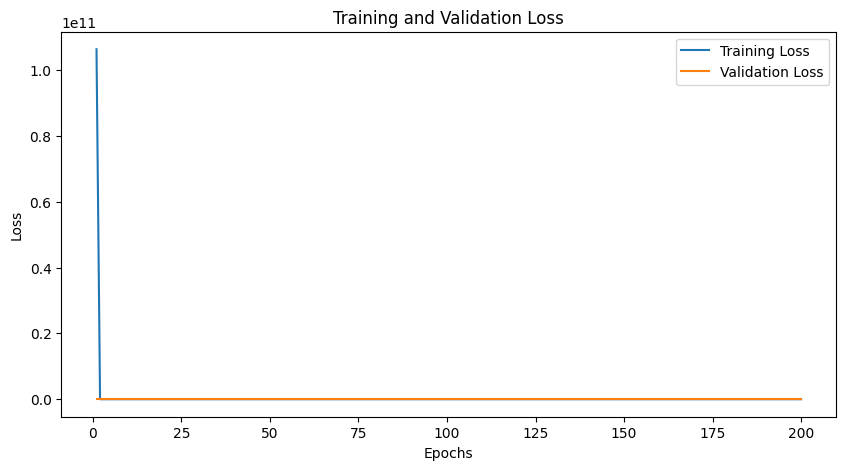

In [159]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [160]:

torch.save(model, 'lstm_Regression_100.pth')


In [161]:
# Load the entire model
model = torch.load('lstm_Regression_100.pth').to(device)
model.eval()  # Set the model to evaluation mode


SpeedPredictor(
  (conv1): Conv1d(7, 64, kernel_size=(1,), stride=(1,))
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True)
  (conv2): Conv1d(128, 64, kernel_size=(1,), stride=(1,))
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

In [162]:
import random
def predict_and_compare(model, test_loader):
    model.eval()  # Ensure the model is in evaluation mode
    predictions = []
    actuals = []
    with torch.no_grad():  # No need to track gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions.extend(outputs.squeeze().tolist())
            actuals.extend(targets.tolist())  # Collect actual target values
    return predictions, actuals

# Assuming val_loader is properly defined and contains test data
predictions, actuals = predict_and_compare(model, val_loader)

def print_random_predictions(predictions, actuals, num_samples=30):
    if len(predictions) < num_samples:
        num_samples = len(predictions)  # Adjust sample size if predictions are fewer than requested

    # Get random sample indices
    sample_indices = random.sample(range(len(predictions)), num_samples)

    # Print the randomly selected predictions and their actual values
    for idx in sample_indices:
        print(f"Predicted: {predictions[idx]:.4f}, Actual: {actuals[idx]:.4f}")

# Assuming you have already executed the predict_and_compare function
# predictions, actuals = predict_and_compare(model, val_loader)

# Now print randomly selected 30 predictions and their actual values
print_random_predictions(predictions, actuals, 30)



Predicted: 35.1714, Actual: 31.0000
Predicted: 33.7627, Actual: 34.0000
Predicted: 44.6178, Actual: 43.0000
Predicted: 61.9219, Actual: 60.0000
Predicted: 55.8323, Actual: 54.0000
Predicted: 64.4156, Actual: 65.0000
Predicted: 49.3562, Actual: 50.0000
Predicted: 60.5510, Actual: 59.0000
Predicted: 77.9434, Actual: 80.0000
Predicted: 38.0737, Actual: 33.0000
Predicted: 40.0868, Actual: 40.0000
Predicted: 55.4345, Actual: 57.0000
Predicted: 37.5808, Actual: 38.0000
Predicted: 40.6468, Actual: 43.0000
Predicted: 90.2593, Actual: 101.0000
Predicted: 50.2315, Actual: 42.0000
Predicted: 89.8025, Actual: 101.0000
Predicted: 67.1998, Actual: 67.0000
Predicted: 77.9385, Actual: 85.0000
Predicted: 74.4476, Actual: 72.0000
Predicted: 70.6157, Actual: 70.0000
Predicted: 42.3188, Actual: 40.0000
Predicted: 75.3594, Actual: 75.0000
Predicted: 58.4986, Actual: 60.0000
Predicted: 35.2228, Actual: 35.0000
Predicted: 59.8108, Actual: 60.0000
Predicted: 93.8917, Actual: 93.0000
Predicted: 45.3731, Actual